In [32]:
import pandas as pd
import numpy as np
import sqlite3
import csv
import matplotlib as plot

# Task 0
Data extraction: get the data from 3 tables & combine it into single `.csv` file.
After that read this file using pandas to create Dataframe.
So it will be all joined data in 1 dataframe. Quick check - should be 74818 rows in it.

In [18]:
with sqlite3.connect("../db.sqlite3") as con:
    data = con.execute(
        """SELECT roi.id, roi.quantity, ro.datetime, rp.price, rp.name
        FROM restaurant_orderitem AS roi
        JOIN restaurant_order ro on ro.id = roi.order_id
        JOIN restaurant_product rp on rp.id = roi.product_id"""
    )
with open("product_data.csv", "w") as data_csv:
    writer = csv.writer(data_csv)
    writer.writerow(["id", "quantity", "datetime", "price", "name"])
    writer.writerows(data)

df = pd.read_csv("product_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74818 entries, 0 to 74817
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        74818 non-null  int64  
 1   quantity  74818 non-null  int64  
 2   datetime  74818 non-null  object 
 3   price     74818 non-null  float64
 4   name      74818 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 2.9+ MB


# Task 1
Get Top 10 most popular products in restaurant sold by Quantity.
Count how many times each product was sold and create a pie chart with percentage of popularity (by quantity) for top 10 of them.

Example:

![pie chart](../demo/pie.png)

<AxesSubplot: title={'center': 'Top 10 position in menu by quantity'}, ylabel='quantity'>

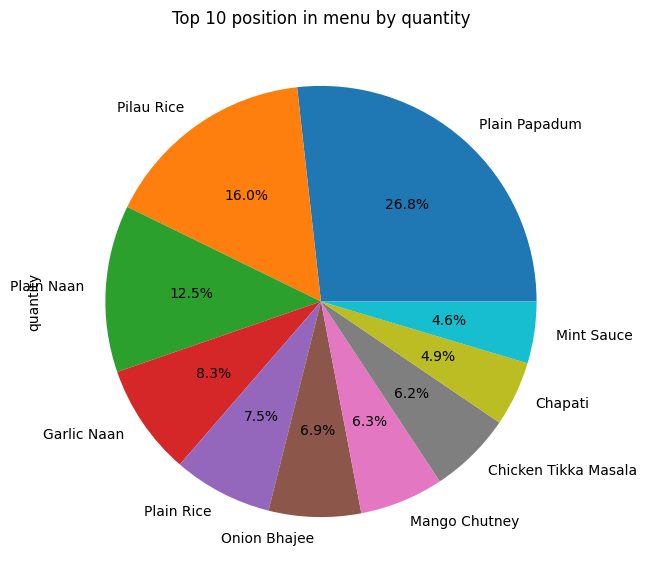

In [54]:
df.groupby("name")["quantity"].sum().sort_values(ascending=False).head(10).plot.pie(
    title="Top 10 position in menu by quantity",
    figsize=(7, 7),
    autopct='%1.1f%%'
)

# Task 2
Calculate `Item Price` (Product Price * Quantity) for each Order Item in dataframe.
And Make the same Top 10 pie chart, but this time by `Item Price`. So this chart should describe not the most popular products by quantity, but which products (top 10) make the most money for restaurant. It should be also with percentage.

<AxesSubplot: title={'center': 'Top 10 position in menu by quantity'}, ylabel='item_price'>

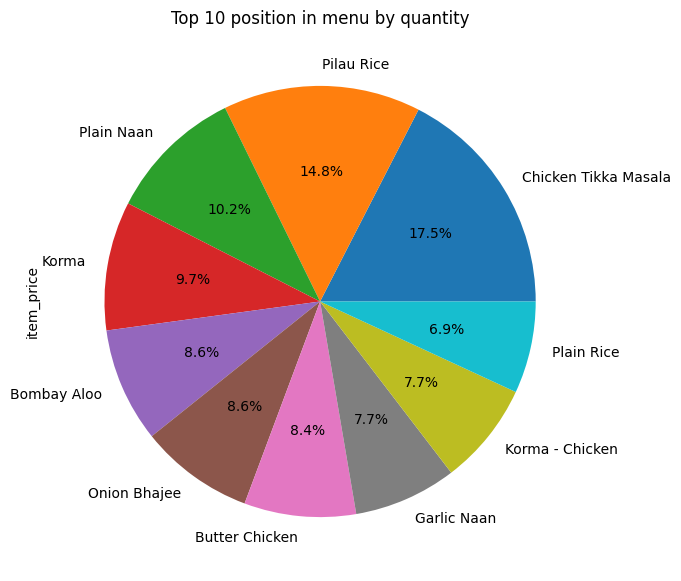

In [59]:
df["item_price"] = df["quantity"] * df["price"]
df.groupby("name")["item_price"].sum().sort_values(ascending=False).head(10).plot.pie(
    title="Top 10 position in menu by item price",
    figsize=(7, 7),
    autopct='%1.1f%%'
)

# Task 3
Calculate `Order Hour` based on `Order Datetime`, which will tell about the specific our the order was created (from 0 to 23). Using `Order Hour` create a bar chart, which will tell the total restaurant income based on the hour order was created. So on x-axis - it will be values from 0 to 23 (hours), on y-axis - it will be the total sum of order prices, which were sold on that hour.

Example:

![bar chart](../demo/bar.png)

<AxesSubplot: xlabel='datetime'>

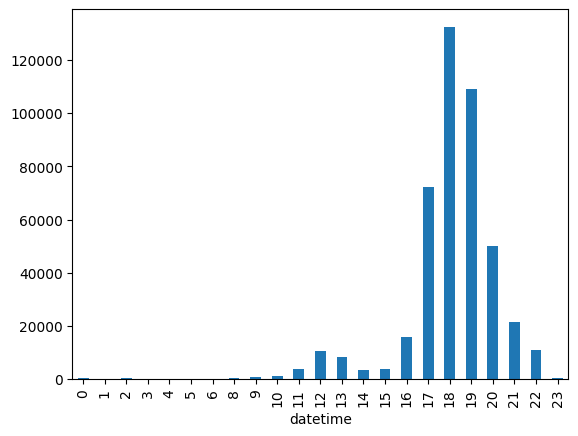

In [80]:
df["datetime"] = pd.to_datetime(df["datetime"])
df.groupby(df["datetime"].dt.hour)["item_price"].sum().plot.bar()

# Task 4
Make similar bar chart, but right now with `Order Day Of The Week` (from Monday to Sunday), and also analyze total restaurant income by each day of the week.

<AxesSubplot: xlabel='datetime'>

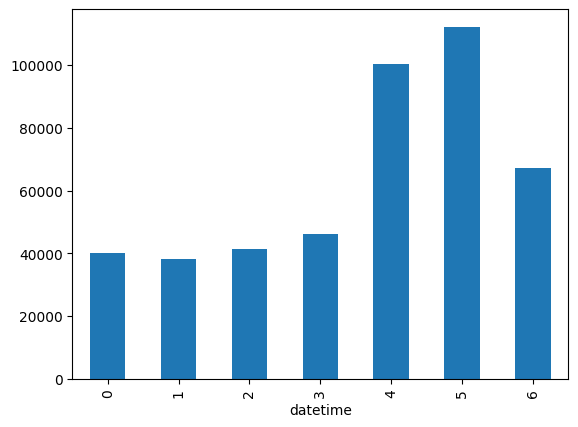

In [82]:
df.groupby(df["datetime"].dt.dayofweek)["item_price"].sum().plot.bar()